# Pylops / Pyproximal - comparison of solvers

### Author: M.Ravasi

In this notebook we will use the proximal gradient algorithm to solve a problem of signal reconstruction and compare its results with ISTA/FISTA or PyLops.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.signal import triang

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.utils import moreau

## 1D Interpolation

Consider the problem of reconstructing a regularly sampled signal of size $M$ from $N$ randomly selected samples:


$$\mathbf{y} = \mathbf{R} \mathbf{x}$$

where

$$\mathbf{y}= [y_1, y_2,...,y_N]^T, \qquad \mathbf{x}= [x_1, x_2,...,x_M]^T, \qquad $$

with $M>>N$ and R selects M elements from x at random locations

Create signal in frequency domain

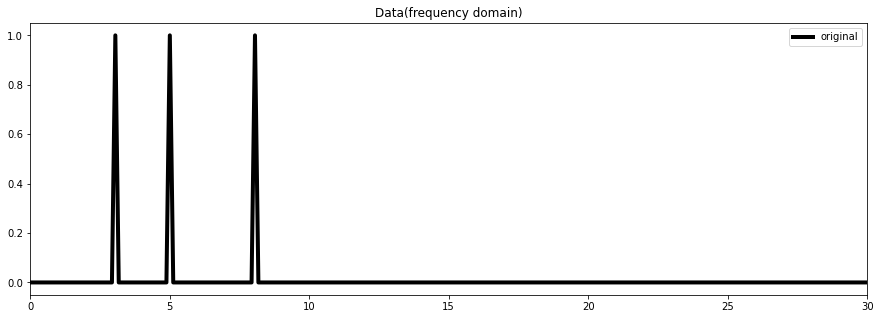

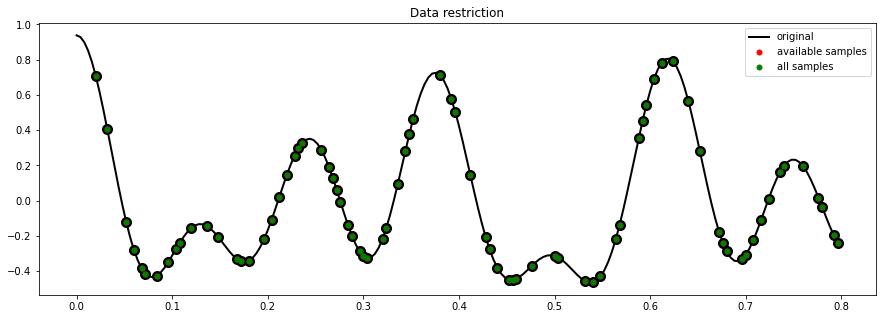

In [2]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(X), 'k', lw=4, label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N)

y     = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,       'k' , lw=2,   label='original')
plt.plot(t[iava], x[iava], '.k', ms=20)
plt.plot(t[iava], y,       '.r', ms=10, label='available samples')
plt.plot(t,       ymask,   '.g', ms=10, label='all samples')
plt.legend()
plt.title('Data restriction');

### Sparsity promoting inversion - Synthesis problem

ISTA

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_98990/3739848412.py:14: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex),


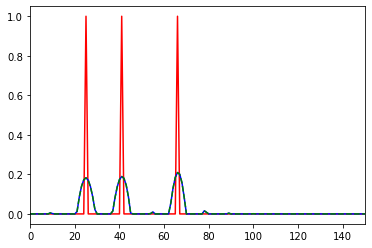

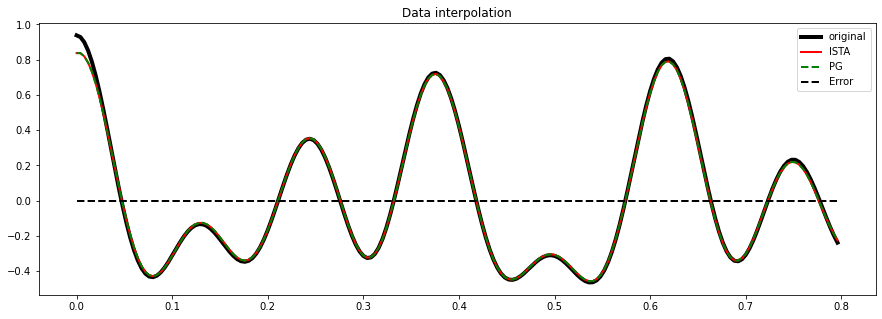

In [3]:
Op = Rop*FFTop.H
L = np.abs((Op.H * Op).eigs(1)[0])
eps = 0.1
niter = 1000
tau= 0.95/L

Xista, niter, cost = ISTA(Op, y, niter=niter, alpha=tau, eps=eps, 
                          tol=1e-8, monitorres=False, returninfo=True, show=False)
xista = FFTop.H*Xista

l1 = L1()
l2 = L2(Op=Op, b=y)
epsg = eps * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5
Xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)
xpg = FFTop.H*Xpg


plt.figure()
plt.plot(np.abs(X),'r')
plt.plot(np.abs(Xista), 'b')
plt.plot(np.abs(Xpg), '--g')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t, x,              'k'   , lw=4,   label='original')
plt.plot(t, xista,  'r' , lw=2,   label='ISTA')
plt.plot(t, xpg,  '--g' , lw=2,   label='PG')
plt.plot(t, xista-xpg,  '--k' , lw=2,   label='Error')
plt.legend()
plt.title('Data interpolation');

Accelerated ISTA and FISTA

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_98990/2798619683.py:6: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Xapg = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex),
/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_98990/2798619683.py:11: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

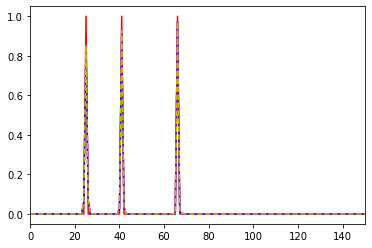

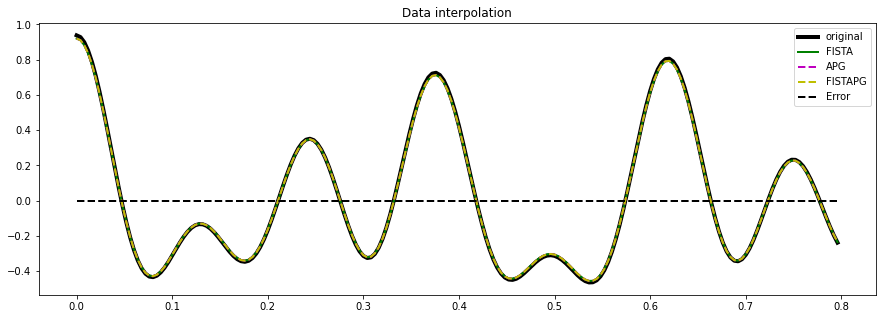

In [4]:
Xfista, niter1, cost1 = FISTA(Op, y, niter=niter, alpha=tau, eps=eps, 
                              tol=1e-8, returninfo=True, show=False)
xfista = FFTop.H*Xfista

# vandenberghe_acc
Xapg = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex), 
                                   epsg=epsg, niter=niter, acceleration='vandenberghe', show=False)
xapg = FFTop.H*Xapg

# fista
Xfistapg = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex), 
                                       epsg=epsg, niter=niter, acceleration='fista', show=False)
xfistapg = FFTop.H*Xfistapg

plt.figure()
plt.plot(np.abs(X),'r')
plt.plot(np.abs(Xfista), 'b')
plt.plot(np.abs(Xapg), '--m')
plt.plot(np.abs(Xfistapg), '--y')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t, x,              'k'   , lw=4,   label='original')
plt.plot(t, xfista,  'g' , lw=2,   label='FISTA')
plt.plot(t, xapg,  '--m' , lw=2,   label='APG')
plt.plot(t, xfistapg,  '--y' , lw=2,   label='FISTAPG')
plt.plot(t, xfista-xfistapg,  '--k' , lw=2,   label='Error')
plt.legend()
plt.title('Data interpolation');

### Sparsity promoting inversion - Analysis problem

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_98990/1635527745.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Rop.dtype = np.complex
/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_98990/1635527745.py:14: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xpg = ProximalGradient(l2, l1, tau=tau, x0

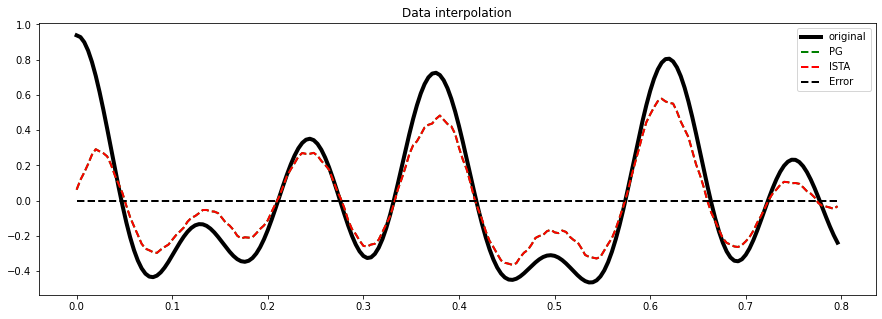

In [5]:
Rop.dtype = np.complex
FFTop1 = FFT(N, nfft=nfft, real=True)
l1 = Orthogonal(L1(), FFTop1)
l2 = L2(Op=Rop, b=y)

L = np.abs((Op.H * Op).eigs(1)[0])
tau= 0.95/L
epsg = eps * 0.5
niter = 1000

xista, niter1, cost1 = ISTA(Rop, y, niter=niter, alpha=tau, eps=eps,  
                            SOp=FFTop1.H, tol=1e-8, returninfo=True, show=False)

xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros_like(x, dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)


fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , lw=4,   label='original')
plt.plot(t,       xpg,  '--g' , lw=2,   label='PG')
plt.plot(t,       xista,  '--r' , lw=2,   label='ISTA')
plt.plot(t, xista-xpg,  '--k' , lw=2,   label='Error')
plt.legend()
plt.title('Data interpolation');

## Deconvolution multiple RHS

In [6]:
Op = Rop*FFTop.H
L = np.abs((Op.H * Op).eigs(1)[0])
eps = 0.1
niter = 1000
tau= 0.95/L

Xista, niter, cost = ISTA(Op, y, niter=niter, alpha=tau, eps=eps, 
                          tol=1e-8, monitorres=False, returninfo=True, show=False)
xista = FFTop.H*Xista

l1 = L1()
l2 = L2(Op=Op, b=y)
epsg = eps * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5
Xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex), 
                       epsg=epsg, niter=niter, show=False)
xpg = FFTop.H*Xpg

/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/ipykernel_98990/3632761489.py:14: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex),


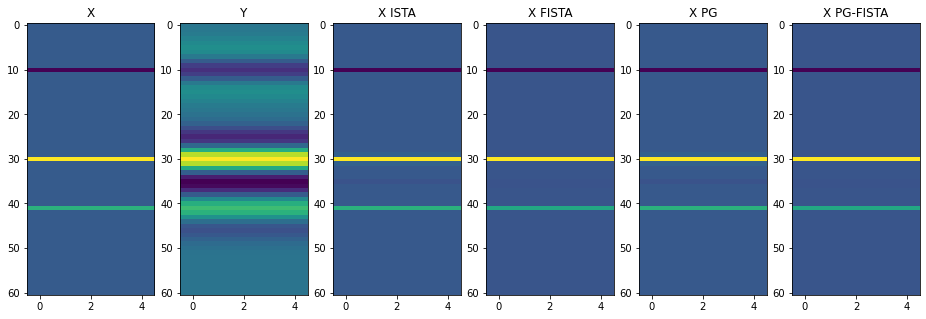

In [7]:
nt = 61
nx = 5
dt = 0.004
t = np.arange(nt)*dt
x = np.zeros(nt)
x[10] = -.4
x[int(nt/2)] = 1
x[nt-20] = 0.5
x = np.outer(x, np.ones(nx))

h, th, hcenter = ricker(t[:101], f0=20)

Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
y = Cop*x

L = np.abs((Cop.H * Cop).eigs(1)[0])
tau= 0.95/L

xista, niteri, costi = ISTA(Cop, y, niter=400, alpha=tau, eps=5e-1,
                            tol=1e-8, returninfo=True)
xfista, niteri, costi = FISTA(Cop, y, niter=400, alpha=tau, eps=5e-1,
                              tol=1e-8, returninfo=True)

l1 = L1()
l2 = L2(Op=Cop, b=y)
epsg = 5e-1 * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5
xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros((nt, nx)), 
                       epsg=epsg, niter=400, show=False)
xpgfista = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros((nt, nx)), 
                       epsg=epsg, niter=400, acceleration='fista', show=False)


fig, axs = plt.subplots(1, 6, figsize=(16, 5))
axs[0].imshow(x)
axs[0].set_title('X')
axs[0].axis('tight')
axs[1].imshow(y)
axs[1].set_title('Y')
axs[1].axis('tight')
axs[2].imshow(xista)
axs[2].set_title('X ISTA')
axs[2].axis('tight')
axs[3].imshow(xfista)
axs[3].set_title('X FISTA')
axs[3].axis('tight')
axs[4].imshow(xpg)
axs[4].set_title('X PG')
axs[4].axis('tight')
axs[5].imshow(xpgfista)
axs[5].set_title('X PG-FISTA')
axs[5].axis('tight');

In [8]:
np.allclose(xista,xpg), np.allclose(xfista,xpgfista)

(True, True)

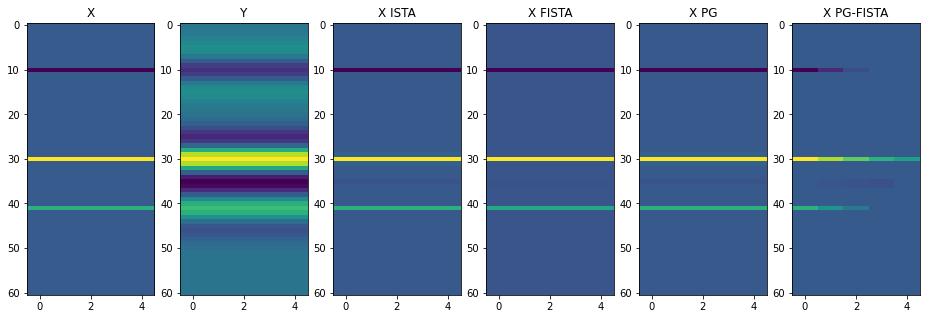

In [15]:
l1 = L1()
l2 = L2(Op=Cop, b=y)
epsg = np.linspace(0.1, 10, 5) * 5e-1 * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5

xpgfista = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros((nt, nx)), 
                       epsg=epsg, niter=400, acceleration='fista', show=False)


fig, axs = plt.subplots(1, 6, figsize=(16, 5))
axs[0].imshow(x)
axs[0].set_title('X')
axs[0].axis('tight')
axs[1].imshow(y)
axs[1].set_title('Y')
axs[1].axis('tight')
axs[2].imshow(xista)
axs[2].set_title('X ISTA')
axs[2].axis('tight')
axs[3].imshow(xfista)
axs[3].set_title('X FISTA')
axs[3].axis('tight')
axs[4].imshow(xpg)
axs[4].set_title('X PG')
axs[4].axis('tight')
axs[5].imshow(xpgfista)
axs[5].set_title('X PG-FISTA')
axs[5].axis('tight');